In [1]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import yaml
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import keras

Using TensorFlow backend.


# 1. Dataset

## 1.1. Carga de datos

Cargamos los datos que obtuvimos del clustering con los equipos, así como los resultados de los partidos.

In [2]:
teams_df = pd.read_csv('../models/teams_EM.csv')
teams_df

,Unnamed: 0,Team,7mPGoals,7mPMissed,6mCGoals,6mCMissed,WingGoals,WingMissed,BTGoals,BTMissed,...,2M,AS,R7,ST,BS,P7,TO,PC1,PC2,cluster
0,0,CRO,16,7,49,12,41,32,20,4,...,28,96,25,33,15,42,98,-3.007976,4.226142,3
1,1,CZE,8,5,4,3,22,10,5,3,...,10,22,13,12,3,24,40,5.047346,0.364696,0
2,2,DEN,20,7,23,15,75,39,21,5,...,25,94,27,39,29,32,84,-3.174269,0.759901,3
3,3,ESP,26,5,24,16,50,39,5,11,...,24,83,31,24,10,21,94,-0.934444,-0.324208,1
4,4,FRA,21,11,36,24,56,34,17,4,...,26,90,32,55,20,34,96,-4.118907,1.369064,3
5,5,GER,15,12,24,12,32,27,22,14,...,27,76,27,26,13,30,72,-1.206175,0.056285,1
6,6,HUN,17,6,14,10,46,36,25,13,...,13,80,24,23,11,25,79,-0.210540,-1.356587,4
7,7,MNE,20,3,25,5,44,47,4,6,...,17,77,23,28,8,20,77,0.477307,-1.030249,4
8,8,NED,21,7,29,8,51,49,23,16,...,22,105,28,34,15,23,81,-2.727188,-1.817280,1
9,9,NOR,35,9,36,14,59,40,44,15,...,18,148,44,34,33,24,75,-5.388616,-3.702451,2


In [3]:
with open('../data/matches.yml', 'r', encoding='utf8') as f:
    matches = yaml.safe_load(f)

## 1.2. Funciones de utilidad

Funciones que serán útiles al procesar los datos. En este caso definimos una para convertir el nombre del país a su abreviatura.

In [4]:
def country_abbr(country_name):
    return {
        'Alemania': 'GER',
        'Croacia': 'CRO',
        'Dinamarca': 'DEN',
        'Eslovenia': 'SLO',
        'España': 'ESP',
        'Francia': 'FRA',
        'Hungría': 'HUN',
        'Montenegro': 'MNE',
        'Noruega': 'NOR',
        'Países Bajos': 'NED',
        'Polonia': 'POL',
        'República Checa': 'CZE',
        'Rumania': 'ROU',
        'Rusia': 'RUS',
        'Serbia': 'SRB',
        'Suecia': 'SWE'
    }[country_name]

## 1.3. Conjuntos de entrenamiento y test

Inicialmente, y según lo que dice el enunciado, vamos a dejar los 24 partidos de la primera fase para la validación del modelo. Por tanto, nos quedamos con los otros 23 partidos de las otras fases para el entrenamiento.

Para cada conjunto de datos necesitamos saber qué equipos conforman cada partido y cuál de los dos fue el ganador. Las etiquetas para el resultado se han definido como:
   - **-1**: Resultado no definido (el partido no se ha jugado)
   - **0**: Empate
   - **1**: Gana el primer equipo
   - **2**: Gana el segundo equipo

In [5]:
train_matches = []
test_matches = []
for phase in matches:
    for group in matches[phase]:
        for match in matches[phase][group]:
            teamA, teamB = match.keys()
            
            if match[teamA] == match[teamB]:
                winner = 'tie'
            else:
                winner = 'first' if match[teamA] > match[teamB] else 'second'

            if phase == 'first':
                test_matches.append([country_abbr(teamA), country_abbr(teamB), winner])
            else:
                train_matches.append([country_abbr(teamA), country_abbr(teamB), winner])
            
print("Train:", train_matches)
print()
print("Test:", test_matches)

Train: [['MNE', 'RUS', 'second'], ['FRA', 'ESP', 'first'], ['FRA', 'RUS', 'tie'], ['DEN', 'SWE', 'first'], ['MNE', 'SWE', 'first'], ['DEN', 'ESP', 'first'], ['MNE', 'ESP', 'tie'], ['FRA', 'SWE', 'first'], ['DEN', 'RUS', 'first'], ['CRO', 'ROU', 'first'], ['NED', 'NOR', 'second'], ['HUN', 'GER', 'second'], ['CRO', 'NOR', 'second'], ['NED', 'GER', 'first'], ['HUN', 'ROU', 'first'], ['NED', 'ROU', 'first'], ['CRO', 'GER', 'first'], ['HUN', 'NOR', 'second'], ['RUS', 'NED', 'first'], ['FRA', 'CRO', 'first'], ['NOR', 'DEN', 'first'], ['CRO', 'DEN', 'first'], ['FRA', 'NOR', 'second']]

Test: [['FRA', 'MNE', 'first'], ['DEN', 'SLO', 'first'], ['SLO', 'FRA', 'second'], ['MNE', 'DEN', 'second'], ['MNE', 'SLO', 'first'], ['FRA', 'DEN', 'first'], ['RUS', 'ESP', 'first'], ['SWE', 'CZE', 'first'], ['CZE', 'RUS', 'second'], ['ESP', 'SWE', 'tie'], ['ESP', 'CZE', 'first'], ['RUS', 'SWE', 'first'], ['HUN', 'CRO', 'second'], ['NED', 'SRB', 'second'], ['SRB', 'HUN', 'second'], ['CRO', 'NED', 'first'], ['S

# 2. Modelo de predicción

Al contrario que en el trabajo de predicción original, con redes neuronales vamos a probar solo dos casos:
   - Utilizar todas las variables (eliminando las que no sean útiles) junto con el clúster obtenido. Mantenemos este caso por la posibilidad de que la red neuronal decida qué variables son más influyentes.
   - Utilizar los resultados del análisis de componentes principales junto con el cluster, ya que fue la opción que dio mejores resultados con KNN.
   
Primero definimos más funciones de utilidad.

In [6]:
def get_match_features(team_features):
    '''
        Duplicamos el vector de características para el primer y el segundo equipo
    '''
    return [*[f'A_{f}' for f in team_features], *[f'B_{f}' for f in team_features]]
    
def generate_data(matches, teams_df, features, augment=False):
    '''
        Generación de un DataFrame que contenga las características elegidas
        para los dos equipos que juegan cada partido.
        
        El parámetro 'augment' permite duplicar los partidos cambiando el orden
        de los equipos (e invirtiendo el resultado). Lo consideramos una forma
        de "data augmentation" para darle robusted al modelo y además compensar
        el volumen tan limitado de datos.
    '''
    data = []
    for match in matches:
        # El partido puede incluir el resultado o no (si es un partido no jugado)
        if len(match) == 3:
            teamA, teamB, result = match
        elif len(match) == 2:
            teamA, teamB = match
            result = None
        
        # Obtenemos las características deseadas de cada equipo
        teamA_data = teams_df.loc[teams_df['Team'] == teamA][features].values.tolist()[0]
        teamB_data = teams_df.loc[teams_df['Team'] == teamB][features].values.tolist()[0]
        
        # Añadimos el partido (junto con las características de los dos equipos) al dataframe
        data.append([teamA, teamB, *teamA_data, *teamB_data, result])
        if augment:
            data.append([
                teamB, teamA,
                *teamB_data, *teamA_data,
                {None:None, 'tie': 'tie', 'first': 'second', 'second': 'first'}[result]
            ])
    
    match_features = get_match_features(features)
    return pd.DataFrame(data=data,
                        columns=['teamA', 'teamB', *match_features, 'result'])


## 2.1. Todas las variables + clúster

Probamos primero a con todas las variables. Podría dar un buen resultado ya que delegamos la elección de las variables significativas a la red neuronal.

In [7]:
team_features = ['7mPGoals', '7mPMissed', '6mCGoals', '6mCMissed', 'WingGoals', 'WingMissed', 'BTGoals', 'BTMissed', 'FBGoals', 'FBMissed', 'FTOGoals', 'FTOMissed', '9mGoals', '9mMissed', 'RC', '2M', 'AS', 'R7', 'ST', 'BS', 'P7', 'TO', 'cluster']
match_features = get_match_features(team_features)

train_df = generate_data(train_matches, teams_df, team_features, augment=True)
test_df = generate_data(test_matches, teams_df, team_features)

train_df

,teamA,teamB,A_7mPGoals,A_7mPMissed,A_6mCGoals,A_6mCMissed,A_WingGoals,A_WingMissed,A_BTGoals,A_BTMissed,...,B_RC,B_2M,B_AS,B_R7,B_ST,B_BS,B_P7,B_TO,B_cluster,result
0,MNE,RUS,20,3,25,5,44,47,4,6,...,0,24,81,21,30,12,28,78,1,second
1,RUS,MNE,15,6,28,6,62,33,23,6,...,0,17,77,23,28,8,20,77,4,first
2,FRA,ESP,21,11,36,24,56,34,17,4,...,1,24,83,31,24,10,21,94,1,first
3,ESP,FRA,26,5,24,16,50,39,5,11,...,1,26,90,32,55,20,34,96,3,second
4,FRA,RUS,21,11,36,24,56,34,17,4,...,0,24,81,21,30,12,28,78,1,tie
5,RUS,FRA,15,6,28,6,62,33,23,6,...,1,26,90,32,55,20,34,96,3,tie
6,DEN,SWE,20,7,23,15,75,39,21,5,...,0,22,75,31,18,8,27,84,1,first
7,SWE,DEN,18,13,34,13,32,25,12,3,...,0,25,94,27,39,29,32,84,3,second
8,MNE,SWE,20,3,25,5,44,47,4,6,...,0,22,75,31,18,8,27,84,1,first
9,SWE,MNE,18,13,34,13,32,25,12,3,...,0,17,77,23,28,8,20,77,4,second


In [8]:
X_train = train_df[match_features]
Y_train = train_df['result']

X_test = test_df[match_features]
Y_test = test_df['result']

In [9]:
from sklearn.preprocessing import LabelEncoder
from keras.utils import to_categorical

encoder = LabelEncoder()
encoded_Y_train = encoder.fit_transform(Y_train)
encoded_Y_test = encoder.transform(Y_test)

onehot_Y_train = to_categorical(encoded_Y_train)

Definimos el modelo. Como tenemos 46 características, ese será el tamaño de la entrada. La salida tendrá un tamaño de 3, ya que tenemos tres clases y estamos usando onehot encoding. Se ha decidido introducir dos capas intermedias escalando poco a poco las características.

In [10]:
from keras.models import Sequential
from keras.layers import Dense

input_dim = len(match_features) # 46

model = Sequential()
model.add(Dense(32, input_dim=input_dim, activation='relu'))
model.add(Dense(16, activation='relu'))
model.add(Dense(8, activation='relu'))
model.add(Dense(3, activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [11]:
from keras.utils import plot_model
plot_model(model, to_file='../figures/Final_NN_model_all.png', show_shapes=True)

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 32)                1504      
_________________________________________________________________
dense_2 (Dense)              (None, 16)                528       
_________________________________________________________________
dense_3 (Dense)              (None, 8)                 136       
_________________________________________________________________
dense_4 (Dense)              (None, 3)                 27        
Total params: 2,195
Trainable params: 2,195
Non-trainable params: 0
_________________________________________________________________


In [18]:
model.fit(X_train, onehot_Y_train, epochs=20, batch_size=4)

Epoch 1/20
46/46 [==============================] - 0s 1ms/step - loss: 0.4743 - acc: 0.7826
Epoch 2/20
46/46 [==============================] - 0s 1ms/step - loss: 0.2665 - acc: 0.9130
Epoch 3/20
46/46 [==============================] - 0s 1ms/step - loss: 0.2069 - acc: 0.9130
Epoch 4/20
46/46 [==============================] - 0s 1ms/step - loss: 0.2085 - acc: 0.9348
Epoch 5/20
46/46 [==============================] - 0s 1ms/step - loss: 0.2126 - acc: 0.9565
Epoch 6/20
46/46 [==============================] - 0s 1ms/step - loss: 0.1979 - acc: 0.9565
Epoch 7/20
46/46 [==============================] - 0s 1ms/step - loss: 0.1853 - acc: 0.9565
Epoch 8/20
46/46 [==============================] - 0s 1ms/step - loss: 0.1782 - acc: 0.9565
Epoch 9/20
46/46 [==============================] - 0s 1ms/step - loss: 0.1844 - acc: 0.9348
Epoch 10/20
46/46 [==============================] - 0s 1ms/step - loss: 0.1849 - acc: 0.9565
Epoch 11/20
46/46 [==============================] - 0s 1ms/step - lo

In [19]:
y_pred = model.predict_classes(X_test)
test_df['nn'] = encoder.inverse_transform(y_pred)
test_df[['result', 'nn']]

,result,nn
0,first,first
1,first,first
2,second,second
3,second,second
4,first,first
5,first,first
6,first,first
7,first,second
8,second,second
9,tie,first


Accuracy: 0.75


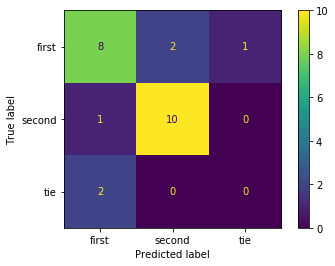

In [20]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

conf_matrix = confusion_matrix(encoded_Y_test, y_pred, labels=[0,1,2])
accuracy = np.diag(conf_matrix).sum() / conf_matrix.sum()
print('Accuracy:', accuracy)

disp = ConfusionMatrixDisplay(
    confusion_matrix=conf_matrix, display_labels=encoder.classes_)
disp.plot()
plt.show()

El resultado parece bueno, aunque es algo peor que el que se obtuvo con KNN. Podría deberse a que tenemos muy pocos datos de entrenamiento por lo que la red no es capaz de converger a una solución mejor.

In [21]:
score = model.evaluate(X_test, to_categorical(encoded_Y_test))
score

24/24 [==============================] - 0s 2ms/step


[1.0704923868179321, 0.75]

## 2.2. Dos componentes principales + clúster

In [22]:
team_features = ['PC1', 'PC2', 'cluster']
match_features = get_match_features(team_features)

train_df = generate_data(train_matches, teams_df, team_features, augment=True)
test_df = generate_data(test_matches, teams_df, team_features)

train_df

,teamA,teamB,A_PC1,A_PC2,A_cluster,B_PC1,B_PC2,B_cluster,result
0,MNE,RUS,0.477307,-1.030249,4.0,-1.043192,0.002938,1.0,second
1,RUS,MNE,-1.043192,0.002938,1.0,0.477307,-1.030249,4.0,first
2,FRA,ESP,-4.118907,1.369064,3.0,-0.934444,-0.324208,1.0,first
3,ESP,FRA,-0.934444,-0.324208,1.0,-4.118907,1.369064,3.0,second
4,FRA,RUS,-4.118907,1.369064,3.0,-1.043192,0.002938,1.0,tie
5,RUS,FRA,-1.043192,0.002938,1.0,-4.118907,1.369064,3.0,tie
6,DEN,SWE,-3.174269,0.759901,3.0,-0.262189,2.119723,1.0,first
7,SWE,DEN,-0.262189,2.119723,1.0,-3.174269,0.759901,3.0,second
8,MNE,SWE,0.477307,-1.030249,4.0,-0.262189,2.119723,1.0,first
9,SWE,MNE,-0.262189,2.119723,1.0,0.477307,-1.030249,4.0,second


In [23]:
X_train = train_df[match_features]
Y_train = train_df['result']

X_test = test_df[match_features]
Y_test = test_df['result']

In [24]:
from sklearn.preprocessing import LabelEncoder
from keras.utils import to_categorical

encoder = LabelEncoder()
encoded_Y_train = encoder.fit_transform(Y_train)
encoded_Y_test = encoder.transform(Y_test)

onehot_Y_train = to_categorical(encoded_Y_train)

En este caso tenemos solo 6 características en la entrada. Una sola capa intermedia podría ser demasiado poco para que el modelo llegue a converger (se ha comprobado), por lo que dejamos dos capas intermedias de tamaño 4. La salida tiene el mismo tamaño que en el caso anterior.

In [25]:
from keras.models import Sequential
from keras.layers import Dense

input_dim = len(match_features) # 6

model = Sequential()
model.add(Dense(6, input_dim=input_dim, activation='relu'))
model.add(Dense(4, activation='relu'))
model.add(Dense(4, activation='relu'))
model.add(Dense(3, activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [26]:
from keras.utils import plot_model
plot_model(model, to_file='../figures/Final_NN_model_pca.png', show_shapes=True)

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_5 (Dense)              (None, 6)                 42        
_________________________________________________________________
dense_6 (Dense)              (None, 4)                 28        
_________________________________________________________________
dense_7 (Dense)              (None, 4)                 20        
_________________________________________________________________
dense_8 (Dense)              (None, 3)                 15        
Total params: 105
Trainable params: 105
Non-trainable params: 0
_________________________________________________________________


In [30]:
model.fit(X_train, onehot_Y_train, epochs=20, batch_size=4)

Epoch 1/20
46/46 [==============================] - 0s 1ms/step - loss: 0.9744 - acc: 0.4565
Epoch 2/20
46/46 [==============================] - 0s 1ms/step - loss: 0.9735 - acc: 0.4565
Epoch 3/20
46/46 [==============================] - 0s 1ms/step - loss: 0.9726 - acc: 0.4565
Epoch 4/20
46/46 [==============================] - 0s 1ms/step - loss: 0.9718 - acc: 0.4565
Epoch 5/20
46/46 [==============================] - 0s 1ms/step - loss: 0.9708 - acc: 0.4565
Epoch 6/20
46/46 [==============================] - 0s 1ms/step - loss: 0.9699 - acc: 0.4565
Epoch 7/20
46/46 [==============================] - 0s 1ms/step - loss: 0.9692 - acc: 0.4565
Epoch 8/20
46/46 [==============================] - 0s 1ms/step - loss: 0.9680 - acc: 0.4565
Epoch 9/20
46/46 [==============================] - 0s 1ms/step - loss: 0.9675 - acc: 0.4565
Epoch 10/20
46/46 [==============================] - 0s 999us/step - loss: 0.9665 - acc: 0.4565
Epoch 11/20
46/46 [==============================] - 0s 1ms/step - 

In [31]:
y_pred = model.predict_classes(X_test)
test_df['nn'] = encoder.inverse_transform(y_pred)
test_df[['result', 'nn']]

,result,nn
0,first,first
1,first,second
2,second,first
3,second,first
4,first,first
5,first,first
6,first,first
7,first,second
8,second,first
9,tie,first


Accuracy: 0.2916666666666667


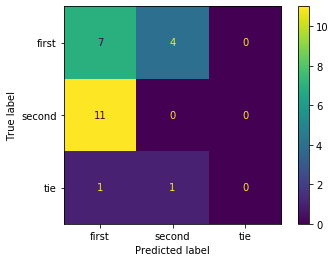

In [32]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

conf_matrix = confusion_matrix(encoded_Y_test, y_pred, labels=[0,1,2])
accuracy = np.diag(conf_matrix).sum() / conf_matrix.sum()
print('Accuracy:', accuracy)

disp = ConfusionMatrixDisplay(
    confusion_matrix=conf_matrix, display_labels=encoder.classes_)
disp.plot()
plt.show()

El resultado es mucho peor que en el caso anterior. Es curioso porque en KNN se obtenía un mejor resultado usando el análisis de componentes principales. Aquí, sin embargo, le estamos quitando información a la red neuronal por lo que no es capaz de generalizar a una solución mejor.

In [33]:
score = model.evaluate(X_test, to_categorical(encoded_Y_test))
score

24/24 [==============================] - 0s 3ms/step


[0.9628820419311523, 0.2916666567325592]